# Jack's Car Rental

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt

In [2]:
MAX_CARS = 20
MAX_MOVE_OF_CARS = 5
EXPECTED_FIRST_LOC_REQUESTS = 3
EXPECTED_SECOND_LOC_REQUESTS = 4
EXPECTED_FIRST_LOC_RETURNS = 3
EXPECTED_SECOND_LOC_RETURNS = 2
DISCOUNT_RATE = 0.9
RENTAL_CREDIT = 10
COST_OF_MOVING = 2

POISSON_UPPER_BOUND = 21

In [3]:
# all of the state-pairs possible (i, j) for "i" showing the number of cars at location1, and "j" for location2
states = [(i, j) for i in range(MAX_CARS + 1) for j in range(MAX_CARS + 1)]
# every possible actions could be done
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

In [4]:
# Calculate poisson distribution
pBackup = dict()

def poisson(x, lam):
    global pBackup
    key = x * 10 + lam
    if key not in pBackup:
        pBackup[key] = np.exp(-lam) * pow(lam, x) / factorial(x)
    return pBackup[key]

In [5]:
def expected_return(state, action, state_value, constant_return=False):
    """
    args:
        state:            [# number of cars at first location, number of cars at second location]
        action:           # number of cars to move from location1 to  location2 (if negative it is vise-vera)
        state_value:      evaluated state_value function that maps each state to the expected return
        constant_return:  if True, returning car is not with respect to poission random variable
    returns:
        q(s, a) - this is same as action_value function
    """
    # initializes the return
    returns = 0.0
    # calculates cost of action that is done (cost of moving cars)
    returns -= COST_OF_MOVING * abs(action)
    # moving cars
    NUM_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # all possiblities that environment could rent and return
    for rent_first_loc in range(POISSON_UPPER_BOUND):
        for rent_second_loc in range(POISSON_UPPER_BOUND):
            # validating rental request: each request to rent out a car should be less than or equal to the number of the cars at each loc
            if rent_first_loc > NUM_CARS_FIRST_LOC or rent_second_loc > NUM_CARS_SECOND_LOC: 
                continue
            # probability of these particular rental request happening
            rental_prob = poisson(rent_first_loc, EXPECTED_FIRST_LOC_REQUESTS) * \
                            poisson(rent_second_loc, EXPECTED_SECOND_LOC_REQUESTS)

            current_num_cars_loc1 = NUM_CARS_FIRST_LOC
            current_num_cars_loc2 = NUM_CARS_SECOND_LOC

            # credit for renting out cars
            reward = (rent_first_loc + rent_second_loc) * RENTAL_CREDIT

            # updating the number of cars at each location after renting out cars
            current_num_cars_loc1 -= rent_first_loc
            current_num_cars_loc2 -= rent_second_loc

            if constant_return:
                # updating the number of cars at each location after cars have been returned
                current_num_cars_loc1 = min(current_num_cars_loc1 + EXPECTED_FIRST_LOC_RETURNS, MAX_CARS)
                current_num_cars_loc2 = min(current_num_cars_loc2 + EXPECTED_SECOND_LOC_RETURNS, MAX_CARS)
                # calculating return
                returns += rental_prob * (reward + DISCOUNT_RATE * state_value[current_num_cars_loc1, current_num_cars_loc2])
            else:
                for return_cars_loc1 in range(POISSON_UPPER_BOUND):
                    for return_cars_loc2 in range(POISSON_UPPER_BOUND):
                        return_prob = poisson(return_cars_loc1, EXPECTED_FIRST_LOC_RETURNS) * \
                                        poisson(return_cars_loc2, EXPECTED_SECOND_LOC_RETURNS)
    
                        # updating the number of cars at each location after cars have been returned
                        current_num_cars_loc1 = min(current_num_cars_loc1 + return_cars_loc1, MAX_CARS)
                        current_num_cars_loc2 = min(current_num_cars_loc2 + return_cars_loc2, MAX_CARS)
    
                        # calculating overall probability of this particular situation happening
                        overall_prob = rental_prob * return_prob
    
                        # calculating return
                        returns += overall_prob * (reward + DISCOUNT_RATE * state_value[current_num_cars_loc1, current_num_cars_loc2])

    return returns

In [6]:
def policy_evaluation(state_value, policy, constant_return = False, theta=1e-8, verbose=True):
    """
    args:
        state_value:      current state_value function that maps each state to the expected return
        policy:           a deterministic policy that maps from state to action
        constant_return:  if True, returning car is not with respect to poission random variable
        theta:            evaluation accuracy, default value if 1e-8
        verbose:          prints out progress
    returns:
        state_value:      evaluated state_value function that maps each state to the expected return
    """
    # initialize new state_value
    new_state_value = state_value.copy()
    
    while True:
        delta = 0
        for state in states:
            # old state_value for this particular state
            v = new_state_value[state]
            # updates new_state_value by one-step-lookahead
            new_state_value[state] = expected_return(state, policy[state], new_state_value, constant_return)
            # updates delta - shows the difference between old state_value and new one
            delta = max(delta, abs(new_state_value[state] - v))
            # if verbose is true
            print(f'\rState: [{state[0]:>3},{state[1]:>3}] Delta is {delta:10.2e}', end='')
        if delta < theta:
            return new_state_value

In [7]:
def policy_improvement(state_value, policy, constant_return=False, verbose=True):
    """
    This function updates policy
    args:
        state_value:      state_value function that maps each state to the expected return
        policy:           a deterministic policy that maps from state to action
        constant_return:  if True, returning car is not with respect to poission random variable
        theta:            evaluation accuracy, default value if 1e-8
    """
    for state in states:
        new_action = 0
        max_value = -np.inf
        for action in actions:
            action_value = expected_return(state, action, state_value, constant_return)
            if action_value > max_value:
                new_action = action
                max_value = action_value

        policy[state] = new_action

        # Printing out the progress
        if verbose:
            print(f'\rState: [{state[0]:>3},{state[1]:>3}]', end='')

In [8]:
def policy_iteration(constant_return=False, theta=1e-8, verbose=True):
    """
    args:
        constant_return:  if True, returning car is not with respect to poission random variable
        theta:            evaluation accuracy, default value if 1e-8
        verbose:          prints out progress
    returns:
        state_value:      evaluated state_value function that maps each state to the expected return
        policy:           a deterministic policy that maps from state to action
    """
    
    # initialize state_value
    state_value = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=np.float32)
    policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=np.int32)

    while True:
        # policy-evaluation
        if verbose: print('Policy Evaluation')
        state_value = policy_evaluation(state_value, policy, constant_return, theta, verbose)
        old_policy = policy.copy()
        # policy-improvement
        if verbose: print('\nPolicy Improvement')
        policy_improvement(state_value, policy, constant_return, verbose)
        if verbose: print()
    
        if np.array_equal(old_policy, policy): 
            return state_value, policy

In [9]:
state_value, policy = policy_iteration(constant_return=True, theta=1e-12)

Policy Evaluation
State: [ 20, 20] Delta is   0.00e+00
Policy Improvement
State: [ 20, 20]
Policy Evaluation
State: [ 20, 20] Delta is   0.00e+00
Policy Improvement
State: [ 20, 20]
Policy Evaluation
State: [ 20, 20] Delta is   0.00e+00
Policy Improvement
State: [ 20, 20]
Policy Evaluation
State: [ 20, 20] Delta is   0.00e+00
Policy Improvement
State: [ 20, 20]
Policy Evaluation
State: [ 20, 20] Delta is   0.00e+00
Policy Improvement
State: [ 20, 20]


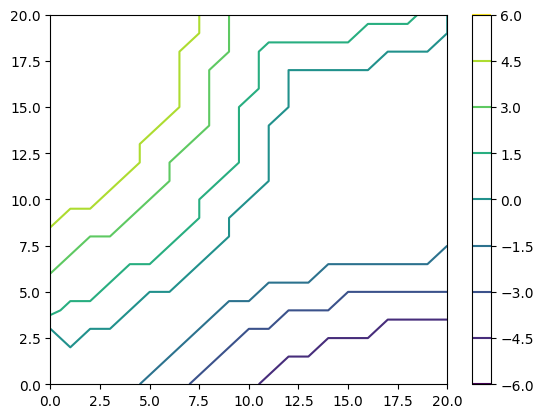

In [10]:
# Create a contour plot with values displayed inside
contour = plt.contour(policy, cmap='viridis')

plt.colorbar()

In [11]:
print(policy)

[[ 0  0  0  0 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
 [ 0  0  0  0 -1 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 -5]
 [ 0  0  0  0  0 -1 -1 -2 -2 -3 -3 -4 -4 -4 -5 -5 -5 -5 -5 -5 -5]
 [ 0  1  0  0  0  0 -1 -1 -2 -2 -3 -3 -3 -4 -4 -4 -4 -5 -5 -5 -5]
 [ 2  1  1  1  0  0  0 -1 -1 -2 -2 -2 -3 -3 -3 -3 -4 -4 -4 -4 -4]
 [ 2  2  2  1  1  0  0  0 -1 -1 -1 -2 -2 -2 -2 -3 -3 -3 -3 -3 -3]
 [ 3  3  2  2  1  1  1  0  0  0 -1 -1 -1 -1 -2 -2 -2 -2 -2 -2 -2]
 [ 4  3  3  2  2  2  1  1  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -2]
 [ 4  4  3  3  3  2  2  1  1  0  0  0  0  0  0  0  0  0  0 -1 -1]
 [ 5  4  4  4  3  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  4  4  3  3  2  1  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  5  4  4  3  2  2  1  1  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  5  5  4  3  3  2  2  1  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  5  5  4  4  3  3  2  1  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5  5  5  5  4  4  3  2  1  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  5